#Conscientious Cars 2: Convolutional Neural Nets

Welcome back to CC: ConscientiousCars! Today, we'll be improving on our system for distinguishing dogs from roads, so we can keep these cute puppers safe.

In [1]:
#@title Run this to load some packages and data! { display-mode: "form" }
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  import gdown
  # gdown.download('https://drive.google.com/uc?id=1-BjeqccJdLiBA6PnNinmXSQ6w5BluLem','cifar_data','True'); # dogs v road;
  !wget -O cifar_data https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));
  
  data   = data_dict['data']
  labels = data_dict['labels']
  
  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  plt.imshow(my_img)
  plt.show()
  
def CNNClassifier(num_epochs=2, layers=1, dropout=0.15):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))
    
    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()
    
def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

In this notebook, we will:

- Use a pre-built CNN function to classify roads vs. dogs.
- Build neural networks from scratch in Keras.
- Experiment with building CNN models from scratch in Keras.
- (Advanced, Optional) Build CNN models for distinguishing cats from dogs, and even experiment with implementing a famous architecture!


**Change Hardware Accelerator to GPU to train faster (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)**

#Loading in Data

Once again, let's load in our dog/road dataset and create our training and test set. **What's the shape of each dataset? Why?**

In [2]:
# load our data
data, labels = load_data()
data = data.astype(float)
labels = categorical_to_numpy(labels)
inputs_train, inputs_test, labels_train, labels_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=1)

--2021-05-29 00:54:25--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3689015 (3.5M) [application/octet-stream]
Saving to: ‘cifar_data’

cifar_data          100%[===================>]   3.52M  --.-KB/s    in 0.02s   

2021-05-29 00:54:25 (184 MB/s) - ‘cifar_data’ saved [3689015/3689015]



# Models for Vision: Convolutional Neural Networks

###Exercise: Exploring Hyperparameters ✍️

As you know, there is a famous type of neural network known as convolutional neural networks (CNNs). These types of neural networks work particularly well on problems to do with computer vision. Let's try one out!

To load up a simple CNN on scikit-learn, just run:

`cnn = CNNClassifier(num_epochs, layers, dropout)`

Work with your instructors to review what each parameter means and how it affects the model! The **dropout** represents how many weights we set to 0 during training time, which can help prevent overfitting.

**Try different values of num_epochs, layers, and dropout so that you get the best possible accuracy on the test set using `model.score()`**!

In [18]:
cnn = CNNClassifier(20, 10, 0.1)
cnn.fit(inputs_train, labels_train)
preds = cnn.predict(inputs_test)
print (cnn.score(inputs_test, labels_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
96/96 - 5s - loss: 0.4281 - accuracy: 0.8125
Epoch 2/20
96/96 - 1s - loss: 0.2191 - accuracy: 0.9146
Epoch 3/20
96/96 - 1s - loss: 0.1886 - accuracy: 0.9354
Epoch 4/20
96/96 - 1s - loss: 0.1611 - accuracy: 0.9417
Epoch 5/20
96/96 - 1s - loss: 0.1476 - accuracy: 0.9573
Epoch 6/20
96/96 - 1s - loss: 0.1251 - accuracy: 0.9479
Epoch 7/20
96/96 - 1s - loss: 0.1005 - accuracy: 0.9708
Epoch 8/20
96/96 - 1s - loss: 0.0943 - accuracy: 0.9677
Epoch 9/20
96/96 - 1s - loss: 0.0822 - accuracy: 0.9771
Epoch 10/20
96/96 - 1s - loss: 0.0648 - accuracy: 0.9750
Epoch 11/20
96/96 - 1s - loss: 0.0713 - accuracy: 0.9760
Epoch 12/20
96/96 - 1s - loss: 0.0497 - accuracy: 0.9823
Epoch 13/20
96/96 - 1s - loss: 0.0531 - accuracy: 0.9771
Epoch 14/20
96/96 - 1s - loss: 0.0399 - accuracy: 0.9865
Epoch 15/20
96/96 - 1s - loss: 0.0429 - accuracy: 0.9854
Epoch 16/20
96/96 - 1s - loss: 0.0317 - accuracy: 0.9937
Epoch 17/20
96/96 - 1s - loss: 0.0279 - accuracy: 0.9958
Epoch 18/20
96/96 - 1s - loss: 0.0168 - 

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


24/24 - 1s
24/24 - 1s - loss: 0.2415 - accuracy: 0.9667
0.9666666388511658


In [4]:
### YOUR CODE HERE
cnn = CNNClassifier(20, 10, 0.1)
cnn.fit(inputs_train, labels_train)
preds = cnn.predict(inputs_test)
print (cnn.score(inputs_test, labels_test))
### END CODE

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


96/96 - 5s - loss: 0.4649 - accuracy: 0.8031
Epoch 2/20
96/96 - 1s - loss: 0.2924 - accuracy: 0.8781
Epoch 3/20
96/96 - 1s - loss: 0.2094 - accuracy: 0.9198
Epoch 4/20
96/96 - 1s - loss: 0.1719 - accuracy: 0.9312
Epoch 5/20
96/96 - 1s - loss: 0.1452 - accuracy: 0.9490
Epoch 6/20
96/96 - 1s - loss: 0.1326 - accuracy: 0.9500
Epoch 7/20
96/96 - 1s - loss: 0.1097 - accuracy: 0.9615
Epoch 8/20
96/96 - 1s - loss: 0.1099 - accuracy: 0.9604
Epoch 9/20
96/96 - 1s - loss: 0.0859 - accuracy: 0.9688
Epoch 10/20
96/96 - 1s - loss: 0.0806 - accuracy: 0.9729
Epoch 11/20
96/96 - 1s - loss: 0.0625 - accuracy: 0.9792
Epoch 12/20
96/96 - 1s - loss: 0.0566 - accuracy: 0.9740
Epoch 13/20
96/96 - 1s - loss: 0.0634 - accuracy: 0.9771
Epoch 14/20
96/96 - 1s - loss: 0.0465 - accuracy: 0.9812
Epoch 15/20
96/96 - 1s - loss: 0.0440 - accuracy: 0.9865
Epoch 16/20
96/96 - 1s - loss: 0.0276 - accuracy: 0.9875
Epoch 17/20
96/96 - 1s - loss: 0.0238 - accuracy: 0.9917
Epoch 18/20
96/96 - 1s - loss: 0.0340 - accuracy: 0

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


24/24 - 1s
24/24 - 1s - loss: 0.3149 - accuracy: 0.9500
0.949999988079071


**How well did your neural network perform?** 

CNNs typically perform better than fully-connected neural networks on vision problems, but, as before, they aren't always consistent. They are also sensitive to a number of parameters. 

## Training and Validation Curves

An important aspect of training neural networks is to prevent overfitting. **How would we recognize overfitting?**

In the first line of code below, we first **fit** the model on the training data and pass in some validation (or test) data to evaluate it. We call it the **history** because we want to retain information about the accuracy at each epoch.

In the second line we plot the history so that we can compare the training and validation accuracies.  

```
history = model.fit(inputs_train, labels_train, validation_data=(inputs_test, labels_test))
plot_acc(history)
```



###Exercise: Plotting a training vs. validation curve for out CNN ✍️

**After how many epochs does the model begin to overfit? How does this vary as you vary the number of hidden layers and dropout?** Overfitting occurs when the validation accuracy starts to drop below the training accuracy.

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


96/96 - 4s - loss: 4.7185 - accuracy: 0.6396 - val_loss: 0.2732 - val_accuracy: 0.8917
Epoch 2/10
96/96 - 0s - loss: 0.9291 - accuracy: 0.7521 - val_loss: 0.2308 - val_accuracy: 0.9083
Epoch 3/10
96/96 - 0s - loss: 0.4959 - accuracy: 0.8365 - val_loss: 0.2716 - val_accuracy: 0.8833
Epoch 4/10
96/96 - 0s - loss: 0.3518 - accuracy: 0.8740 - val_loss: 0.3612 - val_accuracy: 0.8500
Epoch 5/10
96/96 - 0s - loss: 0.2952 - accuracy: 0.8938 - val_loss: 0.2990 - val_accuracy: 0.8625
Epoch 6/10
96/96 - 0s - loss: 0.2805 - accuracy: 0.8917 - val_loss: 0.1892 - val_accuracy: 0.9417
Epoch 7/10
96/96 - 0s - loss: 0.2518 - accuracy: 0.9135 - val_loss: 0.1876 - val_accuracy: 0.9333
Epoch 8/10
96/96 - 0s - loss: 0.2260 - accuracy: 0.9146 - val_loss: 0.1469 - val_accuracy: 0.9542
Epoch 9/10
96/96 - 0s - loss: 0.1969 - accuracy: 0.9354 - val_loss: 0.1403 - val_accuracy: 0.9458
Epoch 10/10
96/96 - 0s - loss: 0.2220 - accuracy: 0.9354 - val_loss: 0.1933 - val_accuracy: 0.9292


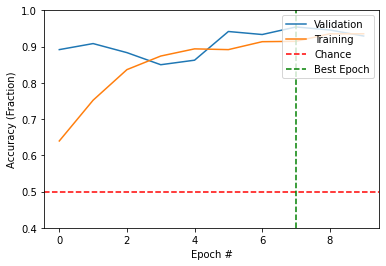

In [5]:
### YOUR CODE HERE
cnn = CNNClassifier(num_epochs=10, layers=3, dropout=0.5)
history = cnn.fit(inputs_train, labels_train, validation_data=(inputs_test, labels_test))
plot_acc(history)
### END CODE

# Building Neural Networks from Scratch in Keras 

So far, we've used helper functions which pre-build Keras neural network models. Now, we will build them on our own!

Let's start with a "toy example": a tiny neural network with 3 inputs.


###Exercise: Building a simple Neural Network using Keras! ✍️




We're going to build this model: 

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as: 
* Input Layer: 3
* Layer 1 (Hidden): 4 neurons that are activated by `'relu'`
* Layer 2 (Output): 2 neurons that are activated by `'softmax'`


We also want to compile the model with
`loss = 'categorical_crossentropy'`

Try filling in the blanks below and walking through each line! **If you want a hint or more details, check out the optional reference below.**

In [6]:
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(Dense(4, input_shape = (3,), activation = 'relu')) 
model_1.add(Dense(2, activation = 'softmax')) 
model_1.compile(loss='categorical_crossentropy',
                optimizer = 'adam', 
                metrics = ['accuracy'])
model_1.predict_classes([[100,-4,-2]]) #Try any input!
### END CODE

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0])

####**Optional Reference**

Here's some information about each step of the process. **You don't need to read through all this - check it as a reference if needed!**

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it. 


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we `add` a `layer` of neurons to our network. 

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers. 

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it** 

After having built the network, we want to train and use it, so we have to 'compile' it to prepare. We have to specify at the very least: a loss (how the model measures the quality of its weights), an optimizer (which adjusts the weights), and a metric (how to evaluate our results). Here are some common choices:
```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```

Once we've created our network, we can use it very simply! Just like we did with sklearn, we define our input data (x), the true predictions from that data (y), and then train our model with `fit`. 

```
model.fit(x, y)
```

To use the model, you can use it to predict something with:
```
y = model.predict_classes(x)
```

You can actually use the model before you even train it! It just won't perform very well. 

###(Optional) Exercise: Building a multi-layer Neural Net using Keras ✍️

![](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

Let's try another, bigger example!

* Input Layer: 3 Neurons

* Layer 1: 4 neurons that are activated by `'relu' `and take in 3 inputs.

* Layer 2: 4 neurons that are activated by `'relu'`

* Layer 3 (out): 1 neurons that is activated by `'sigmoid'`

Compile the model with
`loss = 'binary_crossentropy'`

In [7]:
### YOUR CODE HERE

### END CODE

##Exercise: Building a CNN using Keras! ✍️

Now that we know how to build simple neural networks in Keras, let's build a CNN that will perform well on our data set of car and road images. 

Below is Keras code for a CNN. It will run as-is on the conscientious cars dataset. However, the performance is suboptimal. Add more layers and change the neural network hyperparameters so that the performance will be better. **Can you get the train and validation accuracy to both be higher than 90%?**

The Keras core layer API may be a useful reference: https://keras.io/layers/core/ 

In particular and in addition to adding more of the existing convolutional layers and activations, consider using the following layers after a convolution + activation:

`Dropout(N)`

`MaxPooling2D(pool_size=(N, N))`


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/70
30/30 [==============================] - 2s 31ms/step - loss: 104.7938 - accuracy: 0.5561 - val_loss: 16.8067 - val_accuracy: 0.6708
Epoch 2/70
30/30 [==============================] - 0s 6ms/step - loss: 16.2642 - accuracy: 0.7094 - val_loss: 3.3768 - val_accuracy: 0.8458
Epoch 3/70
30/30 [==============================] - 0s 6ms/step - loss: 12.7390 - accuracy: 0.7561 - val_loss: 2.3552 - val_accuracy: 0.9042
Epoch 4/70
30/30 [==============================] - 0s 6ms/step - loss: 5.1645 - accuracy: 0.8435 - val_loss: 10.7848 - val_accuracy: 0.6708
Epoch 5/70
30/30 [==============================] - 0s 6ms/step - loss: 10.1047 - accuracy: 0.7905 - val_loss: 6.8772 - val_accuracy: 0.7292
Epoch 6/70
30/30 [==============================] - 0s 6ms/step - loss: 4.7093 - accuracy: 0.8464 - val_loss: 0.9939 - val_accuracy: 0.9417
Epoch 7/70
30/30 [==============================] - 0s 6ms/step - loss: 1.4778 - accuracy: 0.9306 - val_loss: 1.6249 - val_accuracy: 0.9375
Epoch 8/70
3

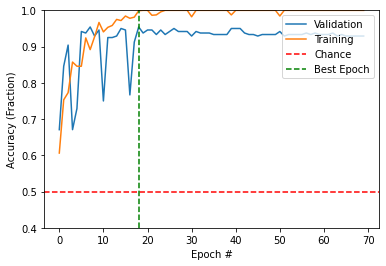

In [8]:
model = Sequential()
model.add(Reshape((32, 32, 3)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the CNN and plot accuracy.
history = model.fit(inputs_train, labels_train, \
                    validation_data=(inputs_test, labels_test), \
                    epochs=70)
plot_acc(history)


**What interesting observations** do you make from the graph? How many epochs should you train for?

We can also print out the structure of our model. What do the parts of the summary mean?

In [9]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_38 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_39 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

#Advanced: Cats vs. Dogs with CNN

So far, we've trained a CNN to distinguish between small images of cats and small images of dogs. It's more challenging and time-consuming to train CNNs for bigger images or harder tasks, like distinguishing dogs from cats (which look a lot more like dogs than roads do!)

In this exercise, you'll adapt your previous model to classify large images of dogs vs. cats, and then try implementing a famous CNN architecture. Along the way, you'll deal with some of the debugging that machine learning engineers often have to handle.

In [10]:
#@title Run this to load cat and dog data. { display-mode: "form" }

#Code here from https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=4PIP1rkmeAYS

import tensorflow as tf
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt

try:
  road_model = model
  road_saved = True
except NameError:
  road_saved = False

IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures
train_image_generator      = ImageDataGenerator()  # Generator for our training data
validation_image_generator = ImageDataGenerator()  # Generator for our validation data
train_data = train_image_generator.flow_from_directory(batch_size=2000,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary').next()
val_data = validation_image_generator.flow_from_directory(batch_size=1000,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)

                                                              class_mode='binary').next()
cd_train_inputs, cd_train_labels = train_data
cd_test_inputs, cd_test_labels = val_data

68608000/68606236 [==============================] - 1s 0us/step
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**Run the code below to see the dimensions of our training and validation data. What does each number mean? What is different than our previous dataset?** 

In [11]:
print (cd_train_inputs.shape) 
print (cd_train_labels.shape) 
print (cd_test_inputs.shape) 
print (cd_test_labels.shape) 

(2000, 150, 150, 3)
(2000,)
(1000, 150, 150, 3)
(1000,)


**Run this code to see a random image from our training data (different each time).**

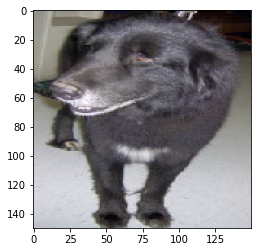

Label: 1.0


In [12]:
index = np.random.randint(len(cd_train_inputs))
plt.imshow(cd_train_inputs[index]/255)
plt.show()
print("Label:",cd_train_labels[index])

**By adapting code from the previous exercise, build, train, and test a CNN to classify cats vs. dogs.**
**Hints:**
*   Use print(model.summary()) for a useful visualization of your model's architecture. Compare the summary of your cat/road and cat/dog classifiers.
*  Substitute the names of the new datasets.
*  Get a "first try" working by making small adjustments to a previous model before trying to optimize the accuracy. You can temporarily comment out layers as you figure things out.
*  The outputs have different shapes betweeen the two datasets. What do you need to change? (You will get an ValueError that suggests how to transform the output to a one-hot encoding.) 
*  If you run out of memory, restart the notebook and/or use your knowledge of convolution arithmetic to reduce the size of an intermediate output (see [Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)).
* Dropout layers help reduce overfitting.


Epoch 1/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


30/30 [==============================] - 4s 47ms/step - loss: 2.7033 - accuracy: 0.6191 - val_loss: 0.3154 - val_accuracy: 0.8625
Epoch 2/70
30/30 [==============================] - 0s 7ms/step - loss: 0.4030 - accuracy: 0.8367 - val_loss: 0.1715 - val_accuracy: 0.9250
Epoch 3/70
30/30 [==============================] - 0s 7ms/step - loss: 0.2515 - accuracy: 0.9075 - val_loss: 0.5318 - val_accuracy: 0.7667
Epoch 4/70
30/30 [==============================] - 0s 8ms/step - loss: 0.2399 - accuracy: 0.9022 - val_loss: 0.1514 - val_accuracy: 0.9333
Epoch 5/70
30/30 [==============================] - 0s 7ms/step - loss: 0.1357 - accuracy: 0.9514 - val_loss: 0.1401 - val_accuracy: 0.9542
Epoch 6/70
30/30 [==============================] - 0s 7ms/step - loss: 0.1520 - accuracy: 0.9433 - val_loss: 0.5999 - val_accuracy: 0.7875
Epoch 7/70
30/30 [==============================] - 0s 6ms/step - loss: 0.2518 - accuracy: 0.8976 - val_loss: 0.5872 - val_accuracy: 0.8083
Epoch 8/70
30/30 [============

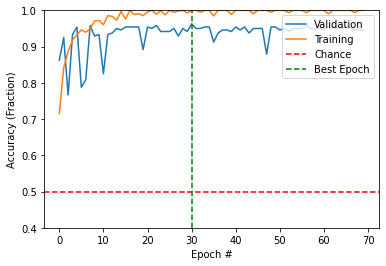

In [13]:
model = Sequential()
model.add(Reshape((32, 32, 3)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the CNN and plot accuracy.
history = model.fit(inputs_train, labels_train, \
                    validation_data=(inputs_test, labels_test), \
                    epochs=70)
plot_acc(history)


#Advanced Challenge: Implementing a Famous Architecture for Cats vs. Dogs

Having trouble designing an effective architecture? Try implementing a version of AlexNet, one of the most famous CNNs for image convolution ever. You can find this image and other useful information on this network [here](https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96).

![](https://lh4.googleusercontent.com/gFAxn9Z-Y1lgkNy2GfsqjXy1DvSuYF8rvP3CslRvmuoP5SUaJMrEOr24YShU_LwalLpYNJFwpJgcDh9whk9XrMOGQ1ADQ9FY_0saicCVH0jsNPDKOYBcTG4YhbqpbPolW4hZSdUsDQ)

How do we read this diagram?

On the left side, we start with images of dimension 227x227x3 (RGB). We apply a filter composed of 96 kernels of size 11x11, with stride size 4. We end up with data of dimension 55x55x96. We pass through multiple layers of convolution and max pooling as shown, before ending with three dense (fully connected) layers.

Not shown: each layer uses ReLU activation, and we include dropout before the first two dense layers. Make sure to include those!

You'll want to adjust some of these dimensions, for a few reasons: we're starting with 150x150 rather than 227x227 images, ending with 2 labels rather than 1000, and have limited data and memory. Use your knowledge of convolution arithmetic (see CNN slides) and the [Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to change the stride, kernel, and/or padding.

Use model.summary() to understand the dimensions of your data at each step. To speed things up as you're building, you can set the number of epochs to 1.

In [14]:
model = Sequential()
#TODO: Your code to run, train, and test AlexNet here:


You might find that even AlexNet isn't working that well for you!

This is because having a good architecture is only half the battle: AlexNet is a complex model designed to learn from millions of images. We're using a small dataset of only 2000 training images, so it's not surprising that our results aren't great. Our model is overfitting: essentially memorizing the few training images, rather than really learning the difference between a cat and a dog. (The advantage is that our model trains quickly.)

To get really good performance, we need more data. If we can't find more, we could use *data augmentation*: inventing new training data by transforming our existing images. You can read more about it at https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html.

![](https://images.pexels.com/photos/316/black-and-white-animal-dog-pet.jpg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)